In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd ./drive/'My Drive'/'pattern recognition'/

/content/drive/My Drive/pattern recognition


In [3]:
import keras
import numpy as np
import os
import random
import numpy as np
import pandas as pd
#import librosa
#import librosa.display
#import matplotlib.pyplot as plt
#import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [4]:
!ls

all.json	model_1.png		       Step05_kNearestNeighbor.ipynb
aug.json	Step01_ImageIO.ipynb	       Step05_kNearestNeighbor.py
cnn_models	Step01_ImageIO.py	       x_test.npy
cnn_models_all	Step02_ImageProcessing.ipynb   x_train_aug.npy
cnn_models_aug	Step02_ImageProcessing.py      x_train.npy
cnn_models_def	Step03_TemplateMatching.ipynb  y_test.npy
def.json	Step03_TemplateMatching.py     y_train_aug.npy
def_mixup.json	Step04_Binarization.ipynb      y_train.npy
Images		Step04_Binarization.py


In [0]:
x_train = np.load('x_train_aug.npy')
y_train = np.load('y_train_aug.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [0]:
from keras.utils import np_utils
classes = 10
# train model
batch_size = 16
epochs = 200
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
onehot_y_train = np_utils.to_categorical(y_train)
onehot_y_test = np_utils.to_categorical(y_test)

In [7]:
print(x_train.shape,x_test.shape)

(10000, 28, 28, 1) (10000, 28, 28, 1)


In [0]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# define CNN
inputs = Input(shape=(28,28,1))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

#model.summary()

#from keras.utils import plot_model
#plot_model(model, to_file='model_1.png')


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# augのみ
model_aug = Model(inputs, x)

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)

# Let's train the model using Adam with amsgrad
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# directory for model checkpoints
model_dir = "./cnn_models_aug"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# early stopping and model checkpoint# early  
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


# ## Train CNN model with between class dataset

history_aug = model.fit(x=x_train, y=onehot_y_train,
                    #steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, onehot_y_test),
                    epochs=epochs, 
                    verbose=1,
                    shuffle=True,
                    callbacks=[es_cb, cp_cb])


import json
f_aug = open('aug.json', 'w')
json.dump(history_aug.history, f_aug)



# ## Evaluate model

model_aug = load_model("./models/?????.hdf5")

evaluation = model.evaluate(x_test, onehot_y_test)
print(evaluation)




10000/10000 [==============================] - 2s 200us/step
[0.32923373027145864, 0.8978]


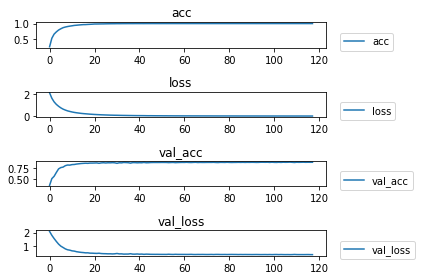

In [0]:
import matplotlib.pyplot as plt
plt.figure()
xx=np.linspace(0, epochs, 1)
plt.subplot(4,1,1)
plt.plot(history_aug.history['acc'],label='acc')
plt.title('acc')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,)
plt.subplot(4,1,2)
plt.plot(history_aug.history['loss'],label='loss')
plt.title('loss')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,)
plt.subplot(4,1,3)
plt.plot(history_aug.history['val_acc'],label='val_acc')
plt.title('val_acc')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,)
plt.subplot(4,1,4)
plt.plot(history_aug.history['val_loss'],label='val_loss')
plt.title('val_loss')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,)
plt.tight_layout()

model_aug = load_model("./cnn_models_aug/esc50_.108_0.3285_0.9004.hdf5")
evaluation = model.evaluate(x_test, onehot_y_test)
print(evaluation)

In [0]:
# all
model_all = Model(inputs, x)

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)

# Let's train the model using Adam with amsgrad
model_all.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# directory for model checkpoints
model_dir = "./cnn_models_all"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# early stopping and model checkpoint# early  
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{val_acc:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


# between class data generator
class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=16, alpha=0.2, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.x_train.shape
        _, class_num = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y
      
training_generator = MixupGenerator(x_train, onehot_y_train)()
history_all = model_all.fit_generator(generator=training_generator,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, onehot_y_test),
                    epochs=epochs, 
                    verbose=1,
                    shuffle=True,
                    callbacks=[es_cb, cp_cb])

import json
f_all = open('all.json', 'w')
json.dump(history_all.history, f_all)


# ## Evaluate model

model_all = load_model("./models/?????.hdf5")

evaluation = model_all.evaluate(x_test, onehot_y_test)
print(evaluation)

Epoch 1/200
625/625 [==============================] - 23s 36ms/step - loss: 2.1322 - acc: 0.2679 - val_loss: 1.9833 - val_acc: 0.4230

Epoch 00001: val_loss improved from inf to 1.98333, saving model to ./cnn_models_all/esc50_.01_1.9833_0.4230.hdf5
Epoch 2/200
625/625 [==============================] - 19s 30ms/step - loss: 1.6367 - acc: 0.5428 - val_loss: 1.6180 - val_acc: 0.5587

Epoch 00002: val_loss improved from 1.98333 to 1.61803, saving model to ./cnn_models_all/esc50_.02_1.6180_0.5587.hdf5
Epoch 3/200
625/625 [==============================] - 18s 28ms/step - loss: 1.3405 - acc: 0.6718 - val_loss: 1.2708 - val_acc: 0.7015

Epoch 00003: val_loss improved from 1.61803 to 1.27082, saving model to ./cnn_models_all/esc50_.03_1.2708_0.7015.hdf5
Epoch 4/200
625/625 [==============================] - 17s 28ms/step - loss: 1.1477 - acc: 0.7515 - val_loss: 1.0380 - val_acc: 0.7565

Epoch 00004: val_loss improved from 1.27082 to 1.03798, saving model to ./cnn_models_all/esc50_.04_1.0380_

OSError: ignored

10000/10000 [==============================] - 2s 227us/step
[0.37110657740831376, 0.8906]


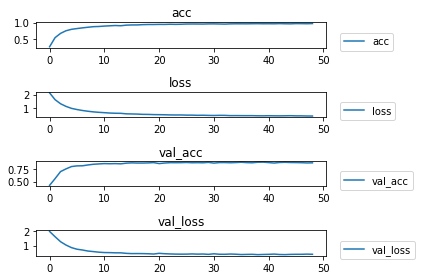

In [0]:
import matplotlib.pyplot as plt
plt.figure()
xx=np.linspace(0, epochs, 1)
plt.subplot(4,1,1)
plt.plot(history_all.history['acc'],label='acc')
plt.title('acc')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,)
plt.subplot(4,1,2)
plt.plot(history_all.history['loss'],label='loss')
plt.title('loss')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,)
plt.subplot(4,1,3)
plt.plot(history_all.history['val_acc'],label='val_acc')
plt.title('val_acc')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,)
plt.subplot(4,1,4)
plt.plot(history_all.history['val_loss'],label='val_loss')
plt.title('val_loss')
plt.legend(loc='upper left',
           bbox_to_anchor=(1.05, 0.5, 0.5, .100), 
           borderaxespad=0.,)
plt.tight_layout()

# ## Evaluate model

model_all = load_model("./cnn_models_all/esc50_.39_0.3711_0.8906.hdf5")

evaluation = model_all.evaluate(x_test, onehot_y_test)
print(evaluation)

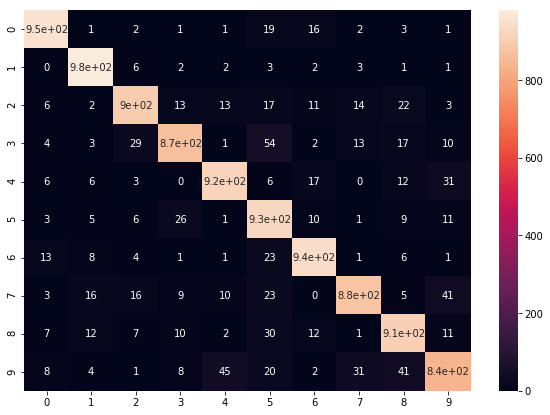

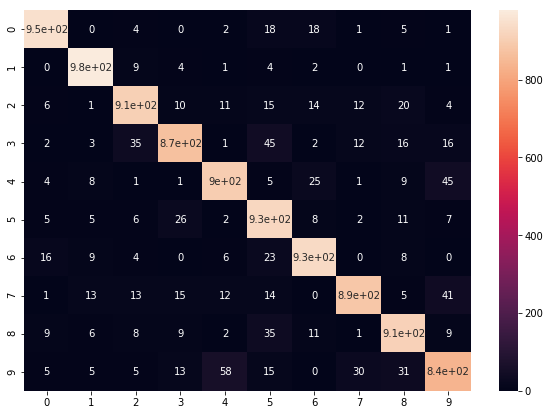

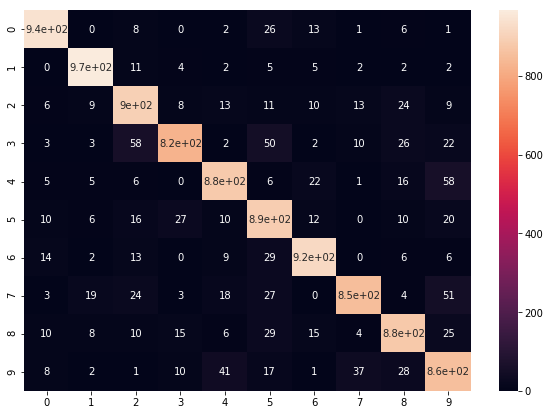

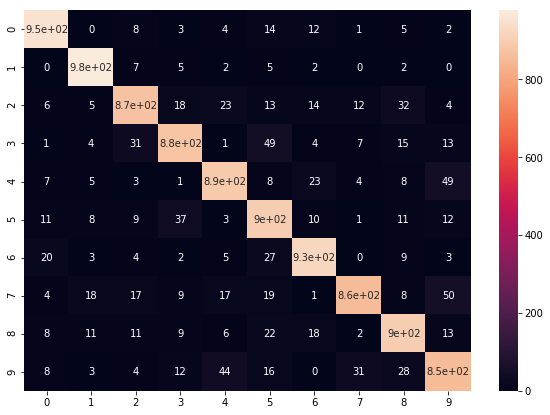

In [17]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
    
def decode(datum):
    dec = []
    for i in datum:
      dec.append(np.argmax(i))
    return dec
  
def print_cmx(y_true, y_pred):
    y_true = decode(y_true)
    y_pred = decode(y_pred)
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, annot=True)
    plt.show()

# ## Evaluate model

model = load_model("./cnn_models/mnist_.200_0.3441_0.9114.hdf5")
pred = model.predict(x_test)
print_cmx(onehot_y_test, pred)

model_def = load_model("./cnn_models_def/mnist_.200_0.3457_0.9101.hdf5")
pred_def = model_def.predict(x_test)
print_cmx(onehot_y_test, pred_def)

model_all = load_model("./cnn_models_all/esc50_.39_0.3711_0.8906.hdf5")
pred_all = model_all.predict(x_test)
print_cmx(onehot_y_test, pred_all)

model_aug = load_model("./cnn_models_aug/esc50_.108_0.3285_0.9004.hdf5")
pred_aug = model_aug.predict(x_test)
print_cmx(onehot_y_test, pred_aug)